In [1]:
import pandas as pd
import numpy as np
import datetime, time, re
from datetime import date
import scipy

import os, os.path, sys
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import NASA_WWAO_core as nc
import NASA_WWAO_plot_core as npc

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data_dir = "./data/"
model_dir = "./model/"
figure_dir = "./figures/"
os.listdir(data_dir)

['Grant_4Fields.zip']

### Define some parameters 

In [3]:
VI_idx = "NDVI"
regular_window_size = 10

In [4]:
size = 12
params = {'legend.fontsize': 15, # medium, large
          # 'figure.figsize': (6, 4),
          'axes.labelsize': size,
          'axes.titlesize': size*1.2,
          'xtick.labelsize': size, #  * 0.75
          'ytick.labelsize': size, #  * 0.75
          'axes.titlepad': 10}

plt.rc('font', family = 'Palatino')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update(params)

### Read the GEE outputs

GEE outputs invlude both ```NDVI``` and ```EVI```. In this demo we work with ```NDVI``` only.

In [6]:
L7 = pd.read_csv(data_dir + "L7_T1C2L2_Grant_4Fields_2021-01-01_2022-01-01.csv")
L8 = pd.read_csv(data_dir + "L8_T1C2L2_Grant_4Fields_2021-01-01_2022-01-01.csv")
L78 = pd.concat([L7, L8])
L78.head(2)

In [6]:
L78.drop(["EVI"], axis=1, inplace=True)
L78 = L78[L78[VI_idx].notna()]

L78 = nc.add_human_start_time_by_system_start_time(L78)
L78.sort_values(by=["ID", "human_system_start_time"], inplace=True)
L78.reset_index(drop=True, inplace=True)
L78.head(2)

,ID,NDVI,system_start_time,human_system_start_time
0,102309_WSDA_SF_2017,0.164733,1.610045e+12,2021-01-07
1,102309_WSDA_SF_2017,0.201906,1.611428e+12,2021-01-23


In [7]:
ID_list = L78["ID"].unique()

In [8]:
"""
  The following function removes na values which we already did above.
  Sometimes EVI violates its theoratical boundary of [-1, 1].
  The function below replaces them with 1.5 and -1.5 as indicators.
  So, it is redundant when using NDVI.
"""
L78 = nc.initial_clean(df=L78, column_to_be_cleaned=VI_idx)

#### Replace outliers

Once again, ```EVI``` would violate its theoratical boundaries. So, the following function ```interpolate_outliers_EVI_NDVI(.)``` is redundant here. But we run it in case of using ```EVI```. Moreover, 
in the following cell we set negative ```VI```s to zero.

In [9]:
noOutlier_df = pd.DataFrame(data=None, index=np.arange(L78.shape[0]), columns=L78.columns)
row_pointer = 0

for a_field in ID_list:
    curr_field = L78[L78["ID"] == a_field].copy()

    if curr_field.shape[0] > 2:
        no_Outlier_TS = nc.interpolate_outliers_EVI_NDVI(outlier_input=curr_field, given_col=VI_idx)
        no_Outlier_TS.loc[no_Outlier_TS[VI_idx] < 0, VI_idx] = 0
        if len(no_Outlier_TS) > 0:
            noOutlier_df[row_pointer : row_pointer + curr_field.shape[0]] = no_Outlier_TS.values
            row_pointer += curr_field.shape[0]

noOutlier_df.head(2)

,ID,NDVI,system_start_time,human_system_start_time
0,102309_WSDA_SF_2017,0.164733,1610045382424.0,2021-01-07 00:00:00
1,102309_WSDA_SF_2017,0.201906,1611427776870.0,2021-01-23 00:00:00


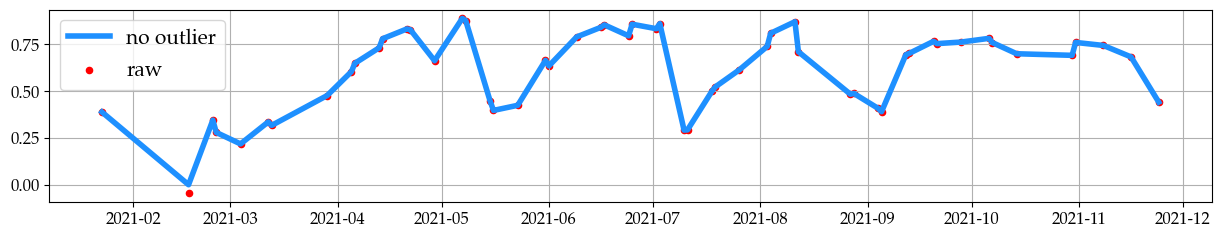

In [10]:
fig, ax_ = plt.subplots(1, 1, figsize=(15, 2.5), sharex=False, sharey='col',
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax_.grid(True);

ax_.plot(noOutlier_df.loc[noOutlier_df.ID==a_field, 'human_system_start_time'], 
         noOutlier_df.loc[noOutlier_df.ID==a_field, VI_idx], 
         linewidth=4, color="dodgerblue", label="no outlier") 

ax_.scatter(L78.loc[L78.ID==a_field, 'human_system_start_time'], 
            L78.loc[L78.ID==a_field, VI_idx], s=20, c="r", label="raw")
ax_.legend(loc="best");

### No big jumps allowed.

In [11]:
noJump_df = pd.DataFrame(data = None, 
                         index = np.arange(noOutlier_df.shape[0]), 
                         columns = noOutlier_df.columns)

row_pointer = 0
for a_field in ID_list:
    curr_field = noOutlier_df[noOutlier_df["ID"]==a_field].copy()
    
    # Sort by DoY (sanitary check)
    curr_field.sort_values(by=['human_system_start_time'], inplace=True)
    curr_field.reset_index(drop=True, inplace=True)

    no_jump_TS = nc.correct_big_jumps_1DaySeries_JFD(dataTMS_jumpie = curr_field, 
                                                     give_col = VI_idx, 
                                                      maxjump_perDay = 0.018)

    noJump_df[row_pointer: row_pointer + curr_field.shape[0]] = no_jump_TS.values
    row_pointer += curr_field.shape[0]

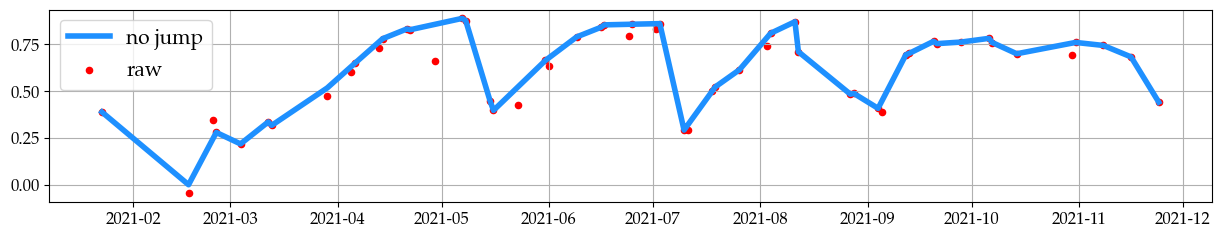

In [12]:
fig, ax_ = plt.subplots(1, 1, figsize=(15, 2.5), sharex=False, sharey='col',
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax_.grid(True);

ax_.plot(noJump_df.loc[noJump_df.ID==a_field, 'human_system_start_time'], 
         noJump_df.loc[noJump_df.ID==a_field, VI_idx], 
         linewidth=4, color="dodgerblue", label="no jump") 

ax_.scatter(L78.loc[L78.ID==a_field, 'human_system_start_time'], 
            L78.loc[L78.ID==a_field, VI_idx], s=20, c="r", label="raw")
ax_.legend(loc="best");

### Regularize
Regularize the time series so that the data are equidistant.

In [13]:
reg_cols = ["ID", "human_system_start_time", VI_idx]
st_yr = 2021
end_yr = 2021
no_days = (end_yr - st_yr + 1) * 366  # 14 years, each year 366 days!
no_steps = no_days // regular_window_size

nrows = no_steps * len(ID_list)
reg_df = pd.DataFrame(data=None, index=np.arange(nrows), columns=reg_cols)

counter = 0
for a_field in ID_list:

    curr_field = noJump_df[noJump_df["ID"] == a_field].copy()
    
    # Sort by DoY (sanitary check)
    curr_field.sort_values(by=["human_system_start_time"], inplace=True)
    curr_field.reset_index(drop=True, inplace=True)

    regularized_TS = nc.regularize_a_field_annual_basis(a_df=curr_field,
                                                        V_idks=VI_idx,
                                                        interval_size=regular_window_size,
                                                        start_year=st_yr,
                                                        end_year=end_yr)
    
    # regularized_TS = regularized_TS[:36].copy()
    regularized_TS = nc.fill_theGap_linearLine(a_regularized_TS=regularized_TS, V_idx=VI_idx)
    row_pointer = no_steps * counter

    """
    The reason for the following line is that we assume all years are 366 days!
    so, the actual thing might be smaller!
    """
    right_pointer = row_pointer + min(no_steps, regularized_TS.shape[0])
    reg_df[row_pointer:right_pointer] = regularized_TS.values
    counter += 1

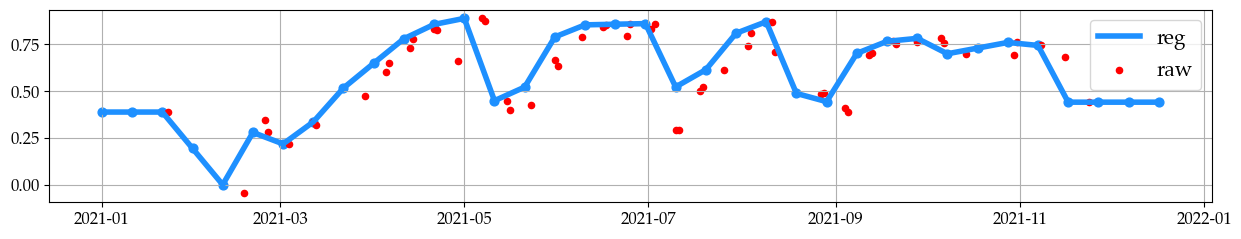

In [14]:
fig, ax_ = plt.subplots(1, 1, figsize=(15, 2.5), sharex=False, sharey='col',
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax_.grid(True);

ax_.plot(reg_df.loc[reg_df.ID==a_field, 'human_system_start_time'], 
         reg_df.loc[reg_df.ID==a_field, VI_idx], 
         linewidth=4, color="dodgerblue", label="reg") 

ax_.scatter(reg_df.loc[reg_df.ID==a_field, 'human_system_start_time'], 
            reg_df.loc[reg_df.ID==a_field, VI_idx], s=40, c="dodgerblue")

ax_.scatter(L78.loc[L78.ID==a_field, 'human_system_start_time'], 
            L78.loc[L78.ID==a_field, VI_idx], s=20, c="r", label="raw")
ax_.legend(loc="best");

### Savitzky-Golay smoothing

In [15]:
SG_df = reg_df.copy()
for a_field in ID_list:
    curr_field = reg_df[reg_df["ID"]==a_field].copy()
    
    # Smoothen by Savitzky-Golay
    SG = scipy.signal.savgol_filter(curr_field[VI_idx].values, window_length=7, polyorder=3)
    SG[SG > 1 ] = 1 # SG might violate the boundaries. clip them:
    SG[SG < -1 ] = -1
    SG_df.loc[curr_field.index, VI_idx] = SG

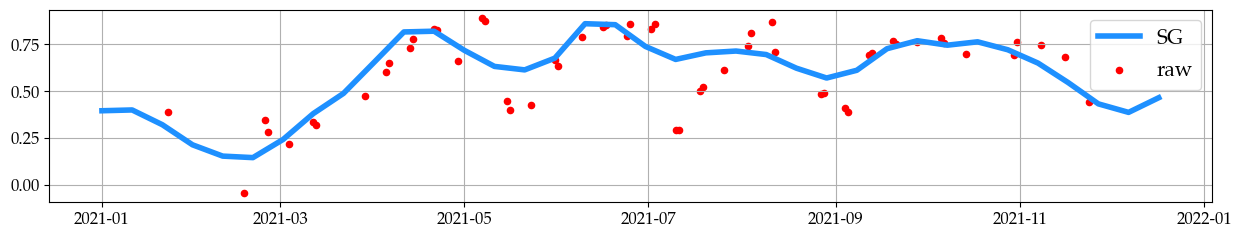

In [16]:
fig, ax_ = plt.subplots(1, 1, figsize=(15, 2.5), sharex=False, sharey='col',
                       gridspec_kw={'hspace': 0.35, 'wspace': .05});
ax_.grid(True);

ax_.plot(SG_df.loc[SG_df.ID==a_field, 'human_system_start_time'], 
         SG_df.loc[SG_df.ID==a_field, VI_idx], 
         linewidth=4, color="dodgerblue", label="SG") 

ax_.scatter(L78.loc[L78.ID==a_field, 'human_system_start_time'], 
            L78.loc[L78.ID==a_field, VI_idx], s=20, c="r", label="raw")
ax_.legend(loc="best");

### Predict via trained DL model

Here we will plot each field and predict, one at a time. 
One can split the task into two steps; first plot all fields, save them on the disk and then read the figures and do the prediction.

First, let us load the trained model.

In [17]:
import h5py

from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16
import tensorflow as tf

from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

ML_model = load_model(model_dir + "TL_NDVI_SG.h5")

2023-09-01 14:11:08.356214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
SG_df["human_system_start_time"] = pd.to_datetime(SG_df["human_system_start_time"])

In [19]:
predictions = pd.DataFrame({"ID": ID_list})
predictions["prob_single"] = -1.0

In [20]:
for a_field in ID_list:
    curr_field = SG_df[SG_df.ID == a_field].copy()
    curr_field.reset_index(drop=True, inplace=True)

    yrs = curr_field.human_system_start_time.dt.year.unique()

    for a_year in yrs:
        ####
        #### plot and save each figure
        ####
        crr_fld_yr = curr_field[curr_field.human_system_start_time.dt.year == a_year]
        crr_fld_yr.reset_index(drop=True, inplace=True)
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 2.5)
        ax.grid(False)
        ax.plot(
            crr_fld_yr["human_system_start_time"], crr_fld_yr[VI_idx], c="dodgerblue", linewidth=5
        )
        ax.axis("off")
        left = crr_fld_yr["human_system_start_time"][0]
        right = crr_fld_yr["human_system_start_time"].values[-1]
        ax.set_xlim([left, right])
        ax.set_ylim([-0.005, 1])
        fig_name = figure_dir + "fig_4_DL.jpg"
        plt.savefig(fname=fig_name, dpi=200, bbox_inches="tight", facecolor="w")
        plt.close("all")
        
        ##
        ## read the image and predict
        ##
        img = nc.load_image(fig_name)
        predictions.loc[predictions.ID==a_field, "prob_single"]= ML_model.predict(img, verbose=False)[0][0]

In [21]:
predictions

,ID,prob_single
0,102309_WSDA_SF_2017,1.00000
1,102385_WSDA_SF_2017,1.00000
2,103372_WSDA_SF_2017,0.99985
3,104563_WSDA_SF_2017,1.00000


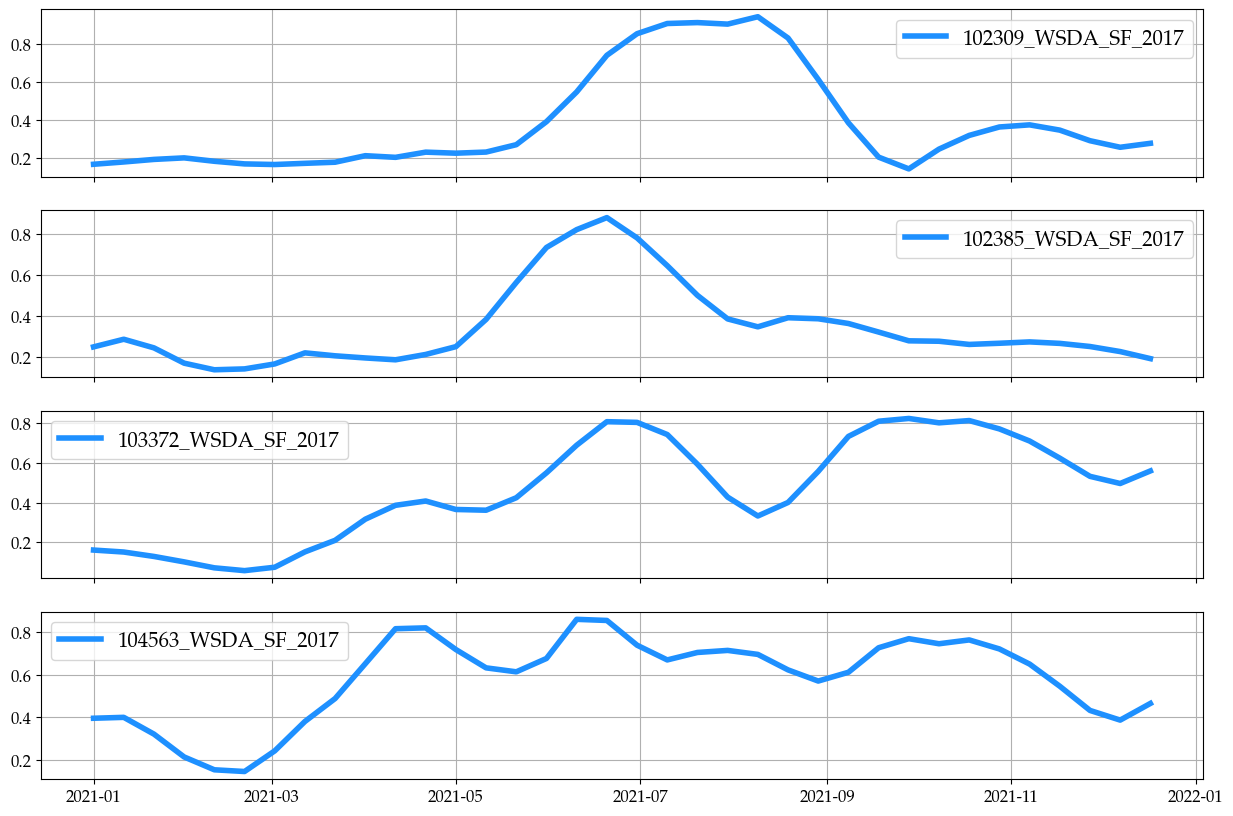

In [22]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.2, 'wspace': .05});

(ax1, ax2, ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True)
ax3.grid(True); ax4.grid(True)

ax1.plot(SG_df.loc[SG_df.ID==ID_list[0], 'human_system_start_time'], 
         SG_df.loc[SG_df.ID==ID_list[0], VI_idx], 
         linewidth=4, color="dodgerblue", label=ID_list[0]);

ax2.plot(SG_df.loc[SG_df.ID==ID_list[1], 'human_system_start_time'], 
         SG_df.loc[SG_df.ID==ID_list[1], VI_idx], 
         linewidth=4, color="dodgerblue", label=ID_list[1]);

ax3.plot(SG_df.loc[SG_df.ID==ID_list[2], 'human_system_start_time'], 
         SG_df.loc[SG_df.ID==ID_list[2], VI_idx], 
         linewidth=4, color="dodgerblue", label=ID_list[2]);

ax4.plot(SG_df.loc[SG_df.ID==ID_list[3], 'human_system_start_time'], 
         SG_df.loc[SG_df.ID==ID_list[3], VI_idx], 
         linewidth=4, color="dodgerblue", label=ID_list[3]);

ax1.legend(loc="best"); ax2.legend(loc="best"); ax3.legend(loc="best"); ax4.legend(loc="best");